Run temporal and spatial ISC within ROIs, fsl 3mm analysis

(1) analyze recap videos

(2) analyze lecture videos

Code for Fig.2, Fig.3, Table 2, Table 3



In [1]:
from os import listdir, makedirs, walk, remove, getlogin, rename
from os.path import isfile, join, exists, isfile, getmtime, isdir
import numpy as np
import socket
import re
from brainiak import image, io, isc
import nibabel as nib
from brainiak.funcalign.srm import SRM
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
#from mpl_toolkits.mplot3d import Axes3D
import pdb
import time
import sys
import pickle
from scipy import stats
import glob
import pandas as pd
from multiprocessing import Pool as ThreadPool
import seaborn as sns

try: # jupyter tools
    from IPython.display import display
    %config InlineBackend.figure_format = 'retina' # for 4k screen
    from IPython.core.interactiveshell import InteractiveShell # for var view
    InteractiveShell.ast_node_interactivity = "all" # for var view
    from mpl_toolkits.mplot3d import Axes3D
except:
    pass

In [2]:
#set paths
my_name = getlogin()

# set system
this_system = socket.gethostname()
print ('Server: '+this_system)

# DATA
bids_path='/mnt/sink/scratch/{}/to_bids'.format(my_name) # raw data
const_data_path = '/mnt/bucket/labs/hasson/'+my_name
const_study_path=join(const_data_path,'onlineL','pred20') # pre-processed data
input_fslfeat_students_path=join(const_study_path,'scan_data_nii','students_mni','6motion') # student pre-processed data
input_fslfeat_experts_path=join(const_study_path,'scan_data_nii','experts_mni','6motion') # expert pre-processed data 
print('DATA: ' + const_study_path)

# CODE
code_path='/mnt/bucket/people/{}/{}/notebooks/share'.format(my_name,my_name[:-2])
print('CODE: ' + code_path)
# SCORES
scores_path=join(bids_path,'sourcedata','exam_scores.tsv')
# MASKS
masks_path=join(code_path,'masks')
# PICKLES
pickles_path=join(const_data_path,'onlineL','shared','pickles')

Server: scotty.pni.Princeton.EDU
DATA: /mnt/bucket/labs/hasson/meshulam/onlineL/pred20
CODE: /mnt/bucket/people/meshulam/meshul/notebooks/share


In [3]:
# import multiple comparisons tools
sys.path.insert(0, join(code_path, 'py'))
from multi_comp import fdr_correction # FDR from the MNE-python package


Part (1): Load ROI definitions

In [4]:
# tasks
all_sessions_and_tasks= sorted(['wk1_vid1', 'wk1_vid2', 'wk1_vid3', 'wk1_vid4', 'wk1_vid5', 'wk2_vid1', 'wk2_vid2', 'wk2_vid3', 'wk3_vid1', 'wk3_vid2', 'wk3_vid3', 'wk3_vid4', 'wk4_vid1', 'wk4_vid2', 'wk4_vid3', 'wk4_vid4', 'wk5_vid1', 'wk5_vid2', 'wk5_vid3', 'wk5_vid4', 'wk5_vid5', 'wk6_wk1recap', 'wk6_wk2recap', 'wk6_wk3recap', 'wk6_wk4recap', 'wk6_wk5recap'])

In [5]:
# masks
listdir(masks_path) #masks, thresholded at thr, from juelich and oxford atlases, mni152, FSL


['MNI152_T1_3mm_brain.nii.gz',
 'Cingulate-ant_3mm_thr20_bin.nii.gz',
 'MNI152_T1_3mm_brain_mask.nii',
 'STG-post_3mm_thr20_bin.nii.gz',
 'Angular_G_3mm_thr20_bin.nii.gz',
 'Heschls_G_3mm_thr20_bin.nii.gz',
 'Hippocampus_3mm_thr20_bin.nii.gz',
 'Amygdala_3mm_thr20_bin.nii.gz',
 'Precuneous_C_3mm_thr20_bin.nii.gz',
 'MNI152_T1_3mm_cortex_mask.nii.gz',
 'Intracalcarine_C_3mm_thr20_bin.nii.gz']

In [6]:
# read anatomical roi files

thr=20 # mask threshold (probability in atlas)
#define midline
midline=30 # right >30, left <30
masks_path
# READ 
print('Loading ROIs from path {}'.format(masks_path))
roi_masks=glob.glob(join(masks_path,'*_thr{}_bin'.format(thr)+'.nii.gz')) #masks, thresholded at thr, from juelich and oxford atlases, mni152, FSL

roi_names=[l.split('/')[-1].split('.')[0].split('_')[0] for l in roi_masks]
masks={}
for this_roi_name, this_roi_mask in zip(roi_names,roi_masks):
    masks[this_roi_name]={}
    masks[this_roi_name]['filename']=this_roi_mask
    masks[this_roi_name]['all_voxels']={}
    masks[this_roi_name]['all_voxels']['bilateral']=nib.load(this_roi_mask).get_fdata()
    masks[this_roi_name]['all_voxels']['left']=masks[this_roi_name]['all_voxels']['bilateral'].copy()
    masks[this_roi_name]['all_voxels']['left'][midline+1:,...]=0 # zero out right side, excl midline
    masks[this_roi_name]['all_voxels']['right']=masks[this_roi_name]['all_voxels']['bilateral'].copy()
    masks[this_roi_name]['all_voxels']['right'][:midline,...]=0 # zero out left side, excl midline
    print('Number of voxels in {} ROI is {}'.format(this_roi_name,int(np.sum(masks[this_roi_name]['all_voxels']['bilateral']))))

save_roi_pickle=True
if save_roi_pickle:        
    pickle_filename=join(pickles_path,'thr{}_roi_dict.p'.format(thr))
    pickle.dump(masks, open(pickle_filename, 'wb'))
sorted(masks.keys())
#masks['Amygdala'].keys()


'/mnt/bucket/people/meshulam/meshul/notebooks/share/masks'

Loading ROIs from path /mnt/bucket/people/meshulam/meshul/notebooks/share/masks
Number of voxels in Cingulate-ant ROI is 1092
Number of voxels in STG-post ROI is 856
Number of voxels in Angular ROI is 1783
Number of voxels in Heschls ROI is 454
Number of voxels in Hippocampus ROI is 668
Number of voxels in Amygdala ROI is 318
Number of voxels in Precuneous ROI is 2845
Number of voxels in Intracalcarine ROI is 925


['Amygdala',
 'Angular',
 'Cingulate-ant',
 'Heschls',
 'Hippocampus',
 'Intracalcarine',
 'Precuneous',
 'STG-post']

In [7]:
#load whole brain
const_mni_brain_file_name = join(masks_path,'MNI152_T1_3mm_brain.nii.gz')
const_mni_brain_mask = join(masks_path,'MNI152_T1_3mm_brain_mask.nii')
whole_brain_3mm=nib.load(const_mni_brain_file_name).get_fdata()
brain_mask_3mm=np.array(nib.load(const_mni_brain_mask).get_fdata(), dtype=bool)
brain_mask_3mm.shape

(61, 73, 61)

In [8]:
# build dict for all filenames, nested

student_and_expert_files=sorted(listdir(input_fslfeat_students_path)+listdir(input_fslfeat_experts_path))
student_and_expert_files=[f for f in student_and_expert_files if f[0]=='s']

task_name_template="(s\d{3})_(wk\d+)_([0-9a-zA-Z]*)_6motion_mni" # FSL data

def build_filenames_dict(student_and_expert_files,task_name_template):
    filenames_dict={}
    filenames_dict['students']={}
    filenames_dict['experts']={}
    for i_this_file,this_file in enumerate(student_and_expert_files):
        dk=re.search(task_name_template,this_file)
        this_subject=str(dk[1])
        this_session=str(dk[2])
        this_task=str(dk[3])
        if this_file[:2]=='s2':
            student_or_expert='experts'
        elif this_file[:2]=='s1':
            student_or_expert='students'
        try:
            temp=type(filenames_dict[student_or_expert][this_subject]) is dict
        except KeyError:
            filenames_dict[student_or_expert][this_subject]={}
        try:
            temp=type(filenames_dict[student_or_expert][this_subject][this_session]) is dict
        except KeyError:
            filenames_dict[student_or_expert][this_subject][this_session]={}
        # write filename to dict
        filenames_dict[student_or_expert][this_subject][this_session][this_task]=join(eval('input_fslfeat_{}_path'.format(student_or_expert)),this_file)
    return filenames_dict

filenames_dict=build_filenames_dict(student_and_expert_files=student_and_expert_files,task_name_template=task_name_template)
# print example
print('Example file in dict:')
filenames_dict['students']['s113']['wk2']['vid1']


Example file in dict:


'/mnt/bucket/labs/hasson/meshulam/onlineL/pred20/scan_data_nii/students_mni/6motion/s113_wk2_vid1_6motion_mni.nii.gz'

In [9]:
def filenames_to_SRM_input_list(input_filenames,brain_mask):
# run once for each of (train, test)
# take filenames and build a data structure (list) for input to SRM, zscored per subject, no nans
# input:
# filenames (list, text)
# brain_mask (assumes it was already read with io.load_boolean_mask and thresholded)
# outputs:
# output_list - SRM input
# function run time
    output_list = [] # output
    t1 = time.time() # timeit
    # coordinates of non-nan voxels
    coords = np.where(brain_mask)
    # io generator
    images=io.load_images(input_filenames)
    # mask images
    images_masked=image.mask_images(images,brain_mask)
    # load and concatenate masked images
    images_concatenated=image.MaskedMultiSubjectData.from_masked_images(images_masked,len(input_filenames)) # dim: TR,vox,subj (unlike old Brainiak, vox X TR X subj)
    # convert nans into zeros
    images_concatenated[np.isnan(images_concatenated)] = 0
    # append to list
    output_list=[None for i in range(len(input_filenames))]
    for this_subject in range(len(input_filenames)):
        # zscore voxels for this subject
        voxels_zscored_this_subject = stats.zscore(images_concatenated[:,:,this_subject],axis=0,ddof=1) # TR X vox
        # reverse the concatenation - required for searchlight
        uncon = np.zeros((*brain_mask.shape, voxels_zscored_this_subject.shape[0])) #(61, 73, 61, TR)
        uncon[coords[0], coords[1], coords[2], :] = np.nan_to_num(voxels_zscored_this_subject.T) # transpose in new pyger
        # append to list
        output_list[this_subject]=uncon # uncon dims: mask X TR (61*73*61*TR)
    t2 = time.time()
    return output_list, t2-t1 # data and runtime

In [ ]:
# get exam data
scores_df=pd.read_csv(scores_path,sep='\t',index_col=[0])
outcomes_df=pd.DataFrame({'placement':scores_df.mean(axis=1)})
outcomes_df # vector of mean exam scores
good_students=[st for st in outcomes_df.index if int(st[1:])<200] # list of students
len(good_students) # number of students

In [11]:
def transform_srm_space_to_isc_space(data_in_srm_space):
    """
    Transform data in srm space (list subjects, each subject is voxel X time array) to data in isc space (array of voxel X time X subject)
    """
    data_in_isc_space=np.zeros((data_in_srm_space[0].shape[0],data_in_srm_space[0].shape[1],len(data_in_srm_space)))
    for s in range(len(data_in_srm_space)):
        data_in_isc_space[:,:,s]=data_in_srm_space[s]
    return data_in_isc_space
    

In [12]:
def func_mean_over_trs(data,tr_length=2,bin_size=30):
    """
    Get binned signal
    parameters: 
    TR length (seconds)
    bin size (seconds)
    data (epi data, voxels X TR)
    output:
    matrix of voxels X bins, where the signal is averaged over TRs within bin
    """
    number_of_bins=np.int(np.floor(data.shape[1]/(bin_size/tr_length))) # number of bins given the params
    end_of_trs=np.int(number_of_bins*bin_size/tr_length) #round such that end of vid is cut, makes sure binsize always equal
    slices = np.linspace(0, end_of_trs, number_of_bins, endpoint=False).astype(np.int) # bin edges
    slices=np.append(slices,end_of_trs)
    counts = np.diff(slices) # size of each bin in TRs
    binned_data = np.add.reduceat(data, slices[:-1],1)/np.tile(counts,(data.shape[0],1))
    return binned_data
#binned_experts=func_mean_over_trs(this_epi_mean_over_experts)
#print(binned_experts)



In [13]:
def plot_regression(x,y,title_text=None):
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print('Least squares linear model coefficients, intercept = ' + str(intercept) + \
      '. Slope = ' + str(slope)+'\n')

    # Create regression line
    regressLine = intercept + x*slope  
    plt.figure()
    plt.clf()
    plt.scatter(x, y, s = 3)
    plt.title(title_text)
    # Add least squares regression line
    plt.plot(x, regressLine, label = 'Least squares regression line'); 



In [14]:
def func_corr_and_null_dist(x,y,num_perms=0):
    """
    returns rval, null distribution for correlation of x,y
    """
    rval = stats.pearsonr(x,y)[0]
    pval = 1
    null_dist=None
    if num_perms>0:
        null_dist=np.array([stats.pearsonr(np.random.permutation(x), y)[0] for n in np.arange(num_perms)])
    return rval,null_dist

In [16]:
def get_title_text(roi_keys,prefix):
    # plotting helper func
    title_text=prefix+'-'
    for i_this_col,this_col in enumerate(roi_keys.keys()):
        if this_col in ['roi_hemi','roi_name']: # skip hemisphere, roi name, in title
            pass
        else:
            item_list=roi_keys[this_col]['select']
            if item_list:
                if len(item_list)>1: # do filter
                    item_list=''.join(['+'+s for s in item_list])[1:]
                else:
                    item_list=item_list[0]
            if item_list:
                title_text+=(this_col+'_'+item_list+'-')
    title_text=title_text[:-1]
    return title_text

In [17]:
def get_filtered_df(roi_keys,unfiltered_df):  
    # run filter using masks
    mask_all_cols=np.zeros(unfiltered_df.shape)
    for i_this_col,this_col in enumerate(roi_keys.keys()):
        item_list=roi_keys[this_col]['select']
        if item_list: # do filter
            mask_this_col=np.zeros([unfiltered_df.shape[0]])
            for this_item in range(len(roi_keys[this_col]['select'])):
                mask_this_col+=(unfiltered_df[this_col]==roi_keys[this_col]['select'][this_item]).values.transpose()
        else: # no filter
            mask_this_col=np.ones([unfiltered_df.shape[0]])
        mask_all_cols[:,i_this_col]=mask_this_col
    # collapse filter masks to a single vec
    mask_collapsed=np.all(mask_all_cols,axis=1)
    # filter dataframe
    this_data_outcome=unfiltered_df[mask_collapsed].copy()
    return this_data_outcome     
              

    #pd.DataFrame
    #unfiltered_df[(unfiltered_df.roi_name=='roi1') &\
    #        (sim_df.roi_type=='thr') &\
    #        (sim_df.corr_w_score=='skip') &\
    #        (sim_df.sim_type=='diagonal') &\
    #        (sim_df.vs_mean_of=='student-vs-experts')\
    #       ]

In [19]:
# init megadict to save all corr results for recap,lectures
#megadict={}

In [20]:
def load_roi_data_for_task(st_files,ex_files,roi_masks,brain_mask,with_bilateral=False):        
    # get files, extract roi data into dict
    # params: student files, expert files (can be empty), roi masks dict, brain mask binary
    # load epi data for all tasks
    students_data, students_data_load_time= filenames_to_SRM_input_list(st_files,brain_mask) 
    print('Students data loaded in {:.2f} seconds'.format(students_data_load_time))
    if ex_files:
        experts_data, experts_data_load_time= filenames_to_SRM_input_list(ex_files,brain_mask) 
        print('Experts data loaded in {:.2f} seconds'.format(experts_data_load_time))    
    else:
        experts_data=None
        print('No experts data found')
        #pass
    #
    if with_bilateral: # include bilateral ROI
        hemispheres=['bilateral']
    else:
        hemispheres=['right','left']
    # extract roi data
    roi_data={}
    roi_data['students']={}
    roi_data['experts']={}
    for this_roi_name in sorted(roi_masks.keys()): # iterate over all rois      
        roi_data['students'][this_roi_name]={}
        roi_data['experts'][this_roi_name]={}
        for this_hemisphere in hemispheres:
            print('ROI {}, {}'.format(this_roi_name, this_hemisphere))
            # extract roi brain data in srm-comatible space (no srm run)
            #students
            st_roi_data=[s[roi_masks[this_roi_name]['all_voxels'][this_hemisphere].nonzero()] for s in students_data] # voxels X trs
            roi_data['students'][this_roi_name][this_hemisphere]=st_roi_data
            # experts
            if experts_data:
                ex_roi_data=[s[roi_masks[this_roi_name]['all_voxels'][this_hemisphere].nonzero()] for s in experts_data] # voxels X trs
                roi_data['experts'][this_roi_name][this_hemisphere]=ex_roi_data
            else:
                roi_data['experts'][this_roi_name][this_hemisphere]=None
    return roi_data

# set to use bilateral ROI 
with_bilateral=True 
hemispheres=['bilateral'] 

In [21]:
# load data for all tasks, save pickle
# builds:
#epi_tasks_in_roi # dict for epi data (all TRs) within each roi
# 42 min to build and save pickles (8.5GB in total for all tasks) for thr=20, bilateral
# 30s to load from pickle

# look up task files
task_dict={}
task_dict['recaps']=sorted([r for r in all_sessions_and_tasks if 'recap' in r and 'wk6' in r])
task_dict['lectures']=sorted([r for r in all_sessions_and_tasks if 'vid' in r and not 'NNvid' in r])
task_dict['all_tasks']=task_dict['recaps']+task_dict['lectures']

load_from_pickle=True # use saved data
save_to_pickle=True # save data

epi_tasks_in_roi={} # dict for epi data (all TRs) within each roi
epi_tasks_in_roi['students']={}
epi_tasks_in_roi['experts']={}

t1=time.time()
for this_task in sorted(task_dict['all_tasks']): #['wk6_wk1recap']: # in recaps # iterate over recap videos
    print(this_task)
    t3=time.time()
    epi_tasks_in_roi['students'][this_task]={}
    epi_tasks_in_roi['experts'][this_task]={}
    # get filenames for task
    all_student_filenames_for_task=sorted([join(input_fslfeat_students_path,f) for f in listdir(input_fslfeat_students_path) if this_task in f and 's1' in f]) 
    selected_students=good_students.copy()                                                     
    epi_tasks_in_roi['students'][this_task]['filenames']=[f for f in all_student_filenames_for_task if f.split('/')[-1].split('_')[0] in selected_students]
    # fetch filenames for experts
    epi_tasks_in_roi['experts'][this_task]['filenames']=sorted([join(input_fslfeat_experts_path,f) for f in student_and_expert_files if this_task in f and 's2' in f])
    
    # get roi data
    st_files=epi_tasks_in_roi['students'][this_task]['filenames']
    ex_files=epi_tasks_in_roi['experts'][this_task]['filenames']
    
    # load roi data from epi or from saved pickle
    task_pickle=join(pickles_path,'{}_roi_data_experts_and_students_dict.p'.format(this_task))
    #with_bilateral=False
    if load_from_pickle:
        epi_roi_dict=pickle.load(open(task_pickle, 'rb'))
    else:
        epi_roi_dict=load_roi_data_for_task(st_files,ex_files,masks,brain_mask_3mm,with_bilateral=with_bilateral) # load
        #save epi roi dict to pickle
        if save_to_pickle:
            pickle.dump(epi_roi_dict, open(task_pickle, 'wb'))

    # update dict
    epi_tasks_in_roi['students'][this_task]['roi_data']=epi_roi_dict['students']
    epi_tasks_in_roi['experts'][this_task]['roi_data']=epi_roi_dict['experts']
    t4=time.time()
    print('This task {} sec'.format(t4-t3))
t2=time.time()
print('Total time: {}'.format(t2-t1)) 
if load_from_pickle:
    print ('Loaded from Pickle')
    

wk1_vid1
This task 0.8352670669555664 sec
wk1_vid2
This task 0.6615595817565918 sec
wk1_vid3
This task 1.9514074325561523 sec
wk1_vid4
This task 0.6794397830963135 sec
wk1_vid5
This task 3.162191867828369 sec
wk2_vid1
This task 4.334330081939697 sec
wk2_vid2
This task 5.0378947257995605 sec
wk2_vid3
This task 0.5219619274139404 sec
wk3_vid1
This task 0.2754955291748047 sec
wk3_vid2
This task 0.7106764316558838 sec
wk3_vid3
This task 0.5059792995452881 sec
wk3_vid4
This task 0.1711266040802002 sec
wk4_vid1
This task 0.5008845329284668 sec
wk4_vid2
This task 0.48950791358947754 sec
wk4_vid3
This task 0.4924347400665283 sec
wk4_vid4
This task 0.40667104721069336 sec
wk5_vid1
This task 0.2410874366760254 sec
wk5_vid2
This task 0.38720703125 sec
wk5_vid3
This task 0.4693281650543213 sec
wk5_vid4
This task 0.6702790260314941 sec
wk5_vid5
This task 0.3647291660308838 sec
wk6_wk1recap
This task 0.29518628120422363 sec
wk6_wk2recap
This task 0.36945557594299316 sec
wk6_wk3recap
This task 0.3765

Part (2): analyze recap videos

In [22]:
# RECAPS
# get signal for experts in recaps, mean over all experts
# (for comparison with each subject) used to compare each subject
epi_mean_over_experts={} #non-zscored
for this_task in sorted([r for r in all_sessions_and_tasks if 'wk6' in r and 'recap' in r]): # iter over wk6 recaps 
    epi_mean_over_experts[this_task]={}
    for this_roi_name in sorted(masks.keys()): # iterate over all rois
        epi_mean_over_experts[this_task][this_roi_name]={}
        for this_hemisphere in hemispheres:
            epi_mean_over_experts[this_task][this_roi_name][this_hemisphere]={}
            for full_or_thresholded in ['full_roi']: 
                print('{}-{}-{}-{}'.format(this_task,this_roi_name,this_hemisphere,full_or_thresholded))
                this_data=epi_tasks_in_roi['experts'][this_task]['roi_data'][this_roi_name][this_hemisphere] # list of subj, vox x TR
                experts_transformed=transform_srm_space_to_isc_space(this_data)
                # note this has already been zscored in time
                experts_mean_subjects=np.nanmean(experts_transformed,2) # mean over experts
                epi_mean_over_experts[this_task][this_roi_name][this_hemisphere]=experts_mean_subjects # vox X TR

                

wk6_wk1recap-Amygdala-bilateral-full_roi
wk6_wk1recap-Angular-bilateral-full_roi
wk6_wk1recap-Cingulate-ant-bilateral-full_roi
wk6_wk1recap-Heschls-bilateral-full_roi
wk6_wk1recap-Hippocampus-bilateral-full_roi
wk6_wk1recap-Intracalcarine-bilateral-full_roi
wk6_wk1recap-Precuneous-bilateral-full_roi
wk6_wk1recap-STG-post-bilateral-full_roi
wk6_wk2recap-Amygdala-bilateral-full_roi
wk6_wk2recap-Angular-bilateral-full_roi
wk6_wk2recap-Cingulate-ant-bilateral-full_roi
wk6_wk2recap-Heschls-bilateral-full_roi
wk6_wk2recap-Hippocampus-bilateral-full_roi
wk6_wk2recap-Intracalcarine-bilateral-full_roi
wk6_wk2recap-Precuneous-bilateral-full_roi
wk6_wk2recap-STG-post-bilateral-full_roi
wk6_wk3recap-Amygdala-bilateral-full_roi
wk6_wk3recap-Angular-bilateral-full_roi
wk6_wk3recap-Cingulate-ant-bilateral-full_roi
wk6_wk3recap-Heschls-bilateral-full_roi
wk6_wk3recap-Hippocampus-bilateral-full_roi
wk6_wk3recap-Intracalcarine-bilateral-full_roi
wk6_wk3recap-Precuneous-bilateral-full_roi
wk6_wk3recap-ST

In [24]:
# RECAPS
# run correlations

# 1) temporal ISC, 2) spatial ISC per TR, 3) spatial 10s bins, 4) spatial 30s bins (for manuscript)
pickle_dicts=['epi_recap_temp_corr_no_bin','epi_recap_spatial_corr_per_tr','epi_recap_spatial_corr_bin_10s','epi_recap_spatial_corr_bin_30s']
num_perms=1000 # for direct comparison (table 3)
load_from_pickle=True # computation takes 1 min
if load_from_pickle:
    for this_dict in pickle_dicts:
        pickle_filename=join(pickles_path,'recaps_roi_data_isc_meanbin_dict_nothr_{}.p'.format(this_dict)) 
        exec('{}=pickle.load(open(pickle_filename, \'rb\'))'.format(this_dict))
        print(pickle_filename)
        print('Loaded')
else: # rerun, don't load from pickle   
    t0=time.time()
    do_direct=True # run direct comparison in 30s bins
    # temporal correlations, no binning
    epi_recap_temp_corr_no_bin={} # repeat for spatial/temp. binning 10s, 30s, not just raw
    # spatial correlation, per tr and w bin 30s,10s
    epi_recap_spatial_corr_per_tr={}
    tr_length=2
    bin_size_seconds_10=10
    epi_recap_spatial_corr_bin_10s={}
    bin_size_seconds_30=30
    epi_recap_spatial_corr_bin_30s={}

    task_name_template=".*(s\d{3}).*(wk\d+)_([0-9a-zA-Z]*)_6motion_mni" # identify subject, session, task
    #for this_task in [r for r in all_sessions_and_tasks if 'recap' in r]:#['wk6_wk2recap']:# # go over all recaps 
    for this_task in sorted([r for r in all_sessions_and_tasks if 'recap' in r and 'wk6' in r]):
        #init dict for task
        epi_recap_temp_corr_no_bin[this_task]={}
        epi_recap_spatial_corr_per_tr[this_task]={}
        epi_recap_spatial_corr_bin_10s[this_task]={}
        epi_recap_spatial_corr_bin_30s[this_task]={}
        for this_roi_name in sorted(masks.keys()): # iterate over all rois
            # init dict for roi
            epi_recap_temp_corr_no_bin[this_task][this_roi_name]={}
            epi_recap_spatial_corr_per_tr[this_task][this_roi_name]={}
            epi_recap_spatial_corr_bin_10s[this_task][this_roi_name]={}
            epi_recap_spatial_corr_bin_30s[this_task][this_roi_name]={}
            for this_hemisphere in hemispheres:
                #init dict for hemisphere
                epi_recap_temp_corr_no_bin[this_task][this_roi_name][this_hemisphere]={}
                epi_recap_spatial_corr_per_tr[this_task][this_roi_name][this_hemisphere]={}
                epi_recap_spatial_corr_bin_10s[this_task][this_roi_name][this_hemisphere]={}
                epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]={}

                #student data
                full_or_thresholded='full_roi' #anat roi
                print('{}-{}-{}-{}'.format(this_task,this_roi_name,this_hemisphere,full_or_thresholded))
                this_data=epi_tasks_in_roi['students'][this_task]['roi_data'][this_roi_name][this_hemisphere]
                this_data_transformed=transform_srm_space_to_isc_space(this_data) # vox, tr, sub - already zscored on time          

                # experts ***wk6*** recap mean for this task (no data for other weeks)
                experts_task='wk6'+this_task[3:]
                print('Expert task correlated: {}'.format(experts_task))
                # this is experts data mean over subjects
                this_epi_mean_over_experts=epi_mean_over_experts[experts_task][this_roi_name][this_hemisphere] # USE FOR EXPERTS
                # this is experts data mean over voxels, for temporal ISC
                experts_mean_over_voxels=np.mean(this_epi_mean_over_experts,0)
                # this is experts data mean over bins in time, for binned spatial ISC
                experts_mean_over_bins_10s=func_mean_over_trs(this_epi_mean_over_experts,bin_size=10)
                # this is experts data mean over bins in time, for binned spatial ISC
                experts_mean_over_bins_30s=func_mean_over_trs(this_epi_mean_over_experts,bin_size=30)

                # debugging: just for comparison, what's the correlation value for mean(experts) and mean(students) - should be the same as in above cell
                do_debug=False
                if do_debug:
                    students_mean_over_voxels=np.mean(np.mean(this_data_transformed,2),0)
                    comp_rval=stats.pearsonr(students_mean_over_voxels,experts_mean_over_voxels)
                    print('Comp rval= {}'.format(comp_rval[0]))
                    fig=plt.figure()
                    ax = fig.add_subplot(111)
                    ax.plot(students_mean_over_voxels)
                    ax.plot(experts_mean_over_voxels)
                    ax.set_title('{}-{}-{}-{}-{:2f}'.format(this_task,this_roi_name,this_hemisphere,full_or_thresholded,comp_rval[0]))

                # temporal correlations
                # for student vs experts mean corr (experts wk6 video)
                corr_student_vs_experts_temporal=np.zeros(this_data_transformed.shape[2],) # for corr result
                # for student vs other students mean mean corr (same video)
                corr_student_vs_other_students_temporal=np.zeros(this_data_transformed.shape[2],) 
                # iterate over students
                for i_this_student in range(len(corr_student_vs_experts_temporal)):
                    # for every student, corr with expert average
                    this_student_mean_over_voxels=np.mean(this_data_transformed[:,:,i_this_student],0)
                    rval_vs_experts=stats.pearsonr(this_student_mean_over_voxels,experts_mean_over_voxels)
                    corr_student_vs_experts_temporal[i_this_student]=rval_vs_experts[0]
                    # for every student, corr with all other students
                    other_students = np.mean(this_data_transformed[:, :, np.arange(this_data_transformed.shape[2]) != i_this_student], axis=2)
                    other_students_mean_over_voxels=np.mean(other_students,0)
                    rval_vs_other_students=stats.pearsonr(this_student_mean_over_voxels,other_students_mean_over_voxels)
                    corr_student_vs_other_students_temporal[i_this_student]=rval_vs_other_students[0]
                #update dict     
                epi_recap_temp_corr_no_bin[this_task][this_roi_name][this_hemisphere]['rvals_vs_experts']=corr_student_vs_experts_temporal # USE TO STORE CORR DATA WITH experts
                epi_recap_temp_corr_no_bin[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=corr_student_vs_other_students_temporal # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_recap_temp_corr_no_bin[this_task][this_roi_name][this_hemisphere]['student_names']=students_list

                # spatial correlations
                number_of_bins_10s=np.int(np.floor(this_data_transformed.shape[1]/(bin_size_seconds_10/tr_length)))
                number_of_bins_30s=np.int(np.floor(this_data_transformed.shape[1]/(bin_size_seconds_30/tr_length)))
                # for student vs experts mean corr (experts wk6 videos)
                corr_student_vs_experts_spatial_per_tr=np.zeros([this_data_transformed.shape[2],this_data_transformed.shape[1]]) #subjects x r per tr # for corr result
                corr_student_vs_experts_spatial_10s=np.zeros([this_data_transformed.shape[2],number_of_bins_10s]) # subjects x r per bin # for corr result
                corr_student_vs_experts_spatial_30s=np.zeros([this_data_transformed.shape[2],number_of_bins_30s]) # subjects x r per bin # for corr result
                # for student vs other students mean mean corr (same video)
                corr_student_vs_other_students_spatial_per_tr=np.zeros([this_data_transformed.shape[2],this_data_transformed.shape[1]]) 
                corr_student_vs_other_students_spatial_10s=np.zeros([this_data_transformed.shape[2],number_of_bins_10s]) 
                corr_student_vs_other_students_spatial_30s=np.zeros([this_data_transformed.shape[2],number_of_bins_30s]) 
                # iterate over students
                for i_this_student in range(len(corr_student_vs_experts_spatial_30s)):
                    # for every student, corr with expert average
                    # per tr
                    this_student_all_trs=this_data_transformed[:,:,i_this_student]
                    temp=np.array([stats.pearsonr(this_student_all_trs[:,i_tr],this_epi_mean_over_experts[:,i_tr])[0] for i_tr in range(this_data_transformed.shape[1])])
                    corr_student_vs_experts_spatial_per_tr[i_this_student]=temp
                    # 10s bins
                    this_student_mean_over_bins_10s=func_mean_over_trs(this_data_transformed[:,:,i_this_student],bin_size=10)              
                    corr_student_vs_experts_spatial_10s[i_this_student,:]=np.array([stats.pearsonr(this_student_mean_over_bins_10s[:,i],experts_mean_over_bins_10s[:,i])[0] for i in range(number_of_bins_10s)])
                    # 30s bins
                    this_student_mean_over_bins_30s=func_mean_over_trs(this_data_transformed[:,:,i_this_student])              
                    corr_student_vs_experts_spatial_30s[i_this_student,:]=np.array([stats.pearsonr(this_student_mean_over_bins_30s[:,i],experts_mean_over_bins_30s[:,i])[0] for i in range(number_of_bins_30s)])
                    # for every student, corr with all other students
                    # per tr
                    other_students = np.mean(this_data_transformed[:, :, np.arange(this_data_transformed.shape[2]) != i_this_student], axis=2) #mean over (other) students
                    temp=np.array([stats.pearsonr(this_student_all_trs[:,i_tr],other_students[:,i_tr])[0] for i_tr in range(this_data_transformed.shape[1])])
                    corr_student_vs_other_students_spatial_per_tr[i_this_student]=temp
                    # 10s bins
                    #other_students = np.mean(this_data_transformed[:, :, np.arange(this_data_transformed.shape[2]) != i_this_student], axis=2)
                    other_students_mean_over_bins_10s=func_mean_over_trs(other_students,bin_size=10)
                    corr_student_vs_other_students_spatial_10s[i_this_student]=np.array([stats.pearsonr(this_student_mean_over_bins_10s[:,i],other_students_mean_over_bins_10s[:,i])[0] for i in range(number_of_bins_10s)])
                    # 30s bins
                    #other_students = np.mean(this_data_transformed[:, :, np.arange(this_data_transformed.shape[2]) != i_this_student], axis=2)
                    other_students_mean_over_bins_30s=func_mean_over_trs(other_students)
                    corr_student_vs_other_students_spatial_30s[i_this_student]=np.array([stats.pearsonr(this_student_mean_over_bins_30s[:,i],other_students_mean_over_bins_30s[:,i])[0] for i in range(number_of_bins_30s)])
                #update dict with the value for mean of bins 
                #no bins
                epi_recap_spatial_corr_per_tr[this_task][this_roi_name][this_hemisphere]['rvals_vs_experts']=np.mean((corr_student_vs_experts_spatial_per_tr),1) # USE TO STORE CORR DATA WITH experts
                epi_recap_spatial_corr_per_tr[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=np.mean((corr_student_vs_other_students_spatial_per_tr),1) # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_recap_spatial_corr_per_tr[this_task][this_roi_name][this_hemisphere]['student_names']=students_list
                #10s bins
                epi_recap_spatial_corr_bin_10s[this_task][this_roi_name][this_hemisphere]['rvals_vs_experts']=np.mean((corr_student_vs_experts_spatial_10s),1) # USE TO STORE CORR DATA WITH experts
                epi_recap_spatial_corr_bin_10s[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=np.mean((corr_student_vs_other_students_spatial_10s),1) # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_recap_spatial_corr_bin_10s[this_task][this_roi_name][this_hemisphere]['student_names']=students_list
                #30s bins
                epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['rvals_vs_experts']=np.mean((corr_student_vs_experts_spatial_30s),1) # USE TO STORE CORR DATA WITH experts
                epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=np.mean((corr_student_vs_other_students_spatial_30s),1) # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['student_names']=students_list
                if do_direct:
                    # direct comparison between experts and group (corr(st vs group,st vs experts)) in 30s bins
                    # dims are different because using students for corr
                    epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['experts_vs_group']={}
                    n_bins=corr_student_vs_experts_spatial_30s.shape[1] # 20 x 6 -> 6
                    direct_dists=np.zeros((n_bins,num_perms)) #6 x 1000
                    direct_rvals=np.zeros((n_bins))
                    # do direct corr
                    for this_bin in range(n_bins):
                        direct_rvals[this_bin],direct_dists[this_bin,:]=\
                            func_corr_and_null_dist(corr_student_vs_experts_spatial_30s[:,this_bin],corr_student_vs_other_students_spatial_30s[:,this_bin],num_perms=num_perms)    
                    # save mean across bins (result)
                    epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['experts_vs_group']['rval_across_st']=np.mean(direct_rvals) # mean rval across bins
                    epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['experts_vs_group']['dist_across_st']=np.mean(direct_dists,axis=0) # mean dist across bins
                    # save per-student values (for direct plots)
                    epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['experts_vs_group']['rvals_per_student']={}
                    epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['experts_vs_group']['rvals_per_student']['_vs_group']=\
                        corr_student_vs_other_students_spatial_30s
                    epi_recap_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['experts_vs_group']['rvals_per_student']['_vs_experts']=\
                        corr_student_vs_experts_spatial_30s
    t1=time.time()
    print('Done in {:.2f} sec'.format(t1-t0))
    do_pickle=True
    #pickle_dicts=['epi_recap_temp_corr_no_bin','epi_recap_spatial_corr_per_tr','epi_recap_spatial_corr_bin_10s','epi_recap_spatial_corr_bin_30s']
    if do_pickle:
        for this_dict in pickle_dicts:
            #pickle_filename=join(output_path,'pickles','recaps_roi_data_isc_dict_{}.p'.format(this_dict)) # this is the multi-dim data (not averaged over time bins)
            pickle_filename=join(pickles_path,'recaps_roi_data_isc_meanbin_dict_nothr_{}.p'.format(this_dict)) 
            pickle.dump(eval(this_dict), open(pickle_filename, 'wb'))


/mnt/bucket/labs/hasson/meshulam/onlineL/shared/pickles/recaps_roi_data_isc_meanbin_dict_nothr_epi_recap_temp_corr_no_bin.p
Loaded
/mnt/bucket/labs/hasson/meshulam/onlineL/shared/pickles/recaps_roi_data_isc_meanbin_dict_nothr_epi_recap_spatial_corr_per_tr.p
Loaded
/mnt/bucket/labs/hasson/meshulam/onlineL/shared/pickles/recaps_roi_data_isc_meanbin_dict_nothr_epi_recap_spatial_corr_bin_10s.p
Loaded
/mnt/bucket/labs/hasson/meshulam/onlineL/shared/pickles/recaps_roi_data_isc_meanbin_dict_nothr_epi_recap_spatial_corr_bin_30s.p
Loaded


In [25]:
megadict={} # keep all corr results in a single dict

In [32]:
# RECAPS
# mean over tasks -recaps - and populate megadict

megadict['recaps']={}
pickle_dicts=['epi_recap_temp_corr_no_bin','epi_recap_spatial_corr_per_tr','epi_recap_spatial_corr_bin_10s','epi_recap_spatial_corr_bin_30s']
for this_dict_name in pickle_dicts:
    print(this_dict_name)
    this_dict=eval(this_dict_name).copy()
    this_task=None
    this_roi=None
    mean_over_tasks_dict={}
    all_tasks_dict={} # all tasks data - for use as features later

    #this_task=for this_task in this_dict.keys():
    for this_roi_name in masks.keys():
        print(this_roi_name)
        mean_over_tasks_dict[this_roi_name]={}
        all_tasks_dict[this_roi_name]={}
        for this_hemi in hemispheres:
            mean_over_tasks_dict[this_roi_name][this_hemi]={}
            all_tasks_dict[this_roi_name][this_hemi]={}
            print(this_hemi)
            for vs in ['rvals_vs_experts', 'rvals_vs_group']:
                print(vs)
                mean_over_tasks_dict[this_roi_name][this_hemi][vs]={}
                all_tasks_dict[this_roi_name][this_hemi][vs]={}
                null_task=list(this_dict.keys())[0]
                n_sub=this_dict[null_task][this_roi_name][this_hemi][vs].shape[0]
                # all_corrs: mean over all tasks
                all_corrs=np.zeros([n_sub,len(this_dict.keys())]) # subjects, tasks
                for i_this_task,this_task in enumerate(this_dict.keys()):
                    all_corrs[:,i_this_task]=this_dict[this_task][this_roi_name][this_hemi][vs]
                # update dict - mean over tasks after Fisher transform
                mean_over_tasks_dict[this_roi_name][this_hemi][vs]=np.tanh(np.mean(np.arctanh(all_corrs),axis=1))
                #mean_over_tasks_dict[this_roi_name][this_hemi][vs]=np.mean(all_corrs,axis=1) # no fisher
                mean_over_tasks_dict[this_roi_name][this_hemi]['student_names']=this_dict[this_task][this_roi_name][this_hemi]['student_names'].copy()
                # update dict - per task
                all_tasks_dict[this_roi_name][this_hemi][vs]=all_corrs.copy()
                all_tasks_dict[this_roi_name][this_hemi]['student_names']=this_dict[this_task][this_roi_name][this_hemi]['student_names'].copy()
            if 'experts_vs_group' in this_dict[this_task][this_roi_name][this_hemi].keys(): # update direct st-ex comparison if exists
                vs='experts_vs_group'
                print(vs)
                all_rval_across_st=np.zeros([len(this_dict.keys())]) # direct rval in every task
                all_dist_across_st=np.zeros([len(this_dict.keys()),num_perms]) # tasks x perms
                for i_this_task,this_task in enumerate(this_dict.keys()):
                    all_rval_across_st[i_this_task]=this_dict[this_task][this_roi_name][this_hemi][vs]['rval_across_st'].copy()
                    all_dist_across_st[i_this_task,:]=this_dict[this_task][this_roi_name][this_hemi][vs]['dist_across_st'].copy()
                # update dict - per task
                all_tasks_dict[this_roi_name][this_hemi][vs]={}
                all_tasks_dict[this_roi_name][this_hemi][vs]['rval_across_st']=all_rval_across_st.copy()
                all_tasks_dict[this_roi_name][this_hemi][vs]['dist_across_st']=all_dist_across_st.copy()
                # update dict - mean over tasks after Fisher transform
                mean_over_tasks_dict[this_roi_name][this_hemi][vs]={}
                rval=np.tanh(np.mean(np.arctanh(all_rval_across_st)))
                dist=np.tanh(np.mean(np.arctanh(all_dist_across_st),axis=0))
                pval = isc.p_from_null(rval,dist,side='right',exact=False,axis=0)
                mean_over_tasks_dict[this_roi_name][this_hemi][vs]['rval']=rval.copy()
                mean_over_tasks_dict[this_roi_name][this_hemi][vs]['pval']=pval.copy()
    # update original dict
    this_dict['mean_over_tasks']=mean_over_tasks_dict
    this_dict['all_tasks']=all_tasks_dict
    #eval(this_dict_name)=this_dict.copy()
    megadict['recaps'][this_dict_name]=this_dict.copy()
    ###

    

epi_recap_temp_corr_no_bin
Cingulate-ant
bilateral
rvals_vs_experts
rvals_vs_group
STG-post
bilateral
rvals_vs_experts
rvals_vs_group
Angular
bilateral
rvals_vs_experts
rvals_vs_group
Heschls
bilateral
rvals_vs_experts
rvals_vs_group
Hippocampus
bilateral
rvals_vs_experts
rvals_vs_group
Amygdala
bilateral
rvals_vs_experts
rvals_vs_group
Precuneous
bilateral
rvals_vs_experts
rvals_vs_group
Intracalcarine
bilateral
rvals_vs_experts
rvals_vs_group
epi_recap_spatial_corr_per_tr
Cingulate-ant
bilateral
rvals_vs_experts
rvals_vs_group
STG-post
bilateral
rvals_vs_experts
rvals_vs_group
Angular
bilateral
rvals_vs_experts
rvals_vs_group
Heschls
bilateral
rvals_vs_experts
rvals_vs_group
Hippocampus
bilateral
rvals_vs_experts
rvals_vs_group
Amygdala
bilateral
rvals_vs_experts
rvals_vs_group
Precuneous
bilateral
rvals_vs_experts
rvals_vs_group
Intracalcarine
bilateral
rvals_vs_experts
rvals_vs_group
epi_recap_spatial_corr_bin_10s
Cingulate-ant
bilateral
rvals_vs_experts
rvals_vs_group
STG-post
bil

Run the following three cells for Fig. 3, table 3 ('direct')

In [29]:
#part A - df
## direct st-ex sim comparison performed in bins 

this_dict_name='epi_recap_spatial_corr_bin_30s'
sim_st_ex_df=pd.DataFrame() # results

# assign mean over tasks to mean_dict
mean_dict=megadict['recaps'][this_dict_name]['mean_over_tasks'].copy()
score_df=outcomes_df.dropna()['placement'] 

# make df for mean (result)
for this_roi_name in ['Hippocampus','Precuneous','Cingulate-ant','Angular','Amygdala','Heschls','STG-post','Intracalcarine']:
#for this_roi_name in masks.keys():
    for this_hemi in ['bilateral']:
        rval=mean_dict[this_roi_name][this_hemi]['experts_vs_group']['rval']
        pval=mean_dict[this_roi_name][this_hemi]['experts_vs_group']['pval']
        
        nvox=int(np.sum(masks[this_roi_name]['all_voxels'][this_hemi]))
        temp_df=pd.DataFrame({'isc_type': 'spatial_bin30s',\
                                               'roi_type': 'anatomical',\
                                               'roi_name': this_roi_name,\
                                               'roi_hemi': this_hemi,\
                                               'n_voxels':nvox,\
                                               'rval':rval,\
                                               'pval':pval},index=[0])
        sim_st_ex_df=sim_st_ex_df.append(temp_df)
        
        
# calc fdr and show result df       
sim_st_ex_df['fdr_pval']=fdr_correction(sim_st_ex_df.pval)[1]
sim_st_ex_df



,isc_type,roi_type,roi_name,roi_hemi,n_voxels,rval,pval,fdr_pval
0,spatial_bin30s,anatomical,Hippocampus,bilateral,668,0.083704,0.020979,0.023976
0,spatial_bin30s,anatomical,Precuneous,bilateral,2845,0.428380,0.000999,0.001998
0,spatial_bin30s,anatomical,Cingulate-ant,bilateral,1092,0.134750,0.001998,0.003197
0,spatial_bin30s,anatomical,Angular,bilateral,1783,0.468916,0.000999,0.001998
0,spatial_bin30s,anatomical,Amygdala,bilateral,318,0.085407,0.025974,0.025974
0,spatial_bin30s,anatomical,Heschls,bilateral,454,0.120928,0.002997,0.003996
0,spatial_bin30s,anatomical,STG-post,bilateral,856,0.246970,0.000999,0.001998
0,spatial_bin30s,anatomical,Intracalcarine,bilateral,925,0.632837,0.000999,0.001998


16


Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Alignment to experts')

(-0.4, 1.1)

(-0.4, 1.1)

Text(0.5, 1.0, 'Direct st-ex alignment corr in\nCingulate-ant-bilateral\nrval=0.117')

Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Alignment to experts')

(-0.4, 1.1)

(-0.4, 1.1)

Text(0.5, 1.0, 'Direct st-ex alignment corr in\nCingulate-ant-bilateral\nrval=0.809')

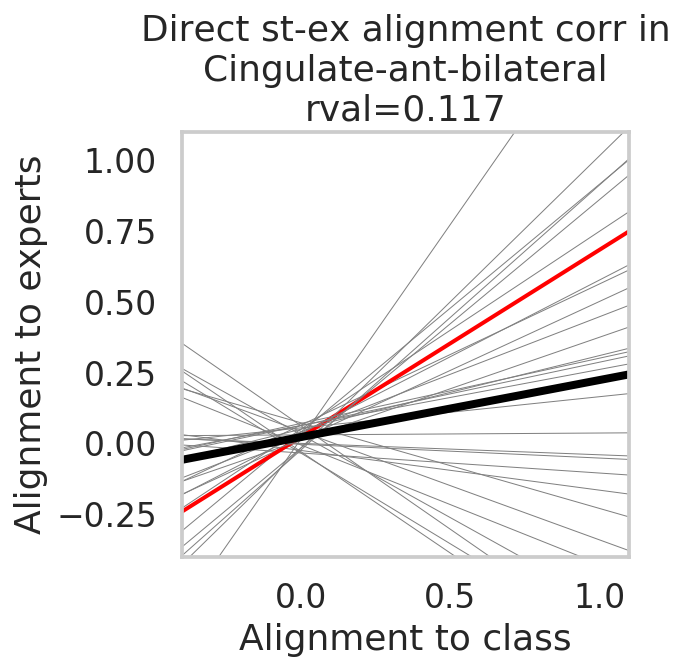

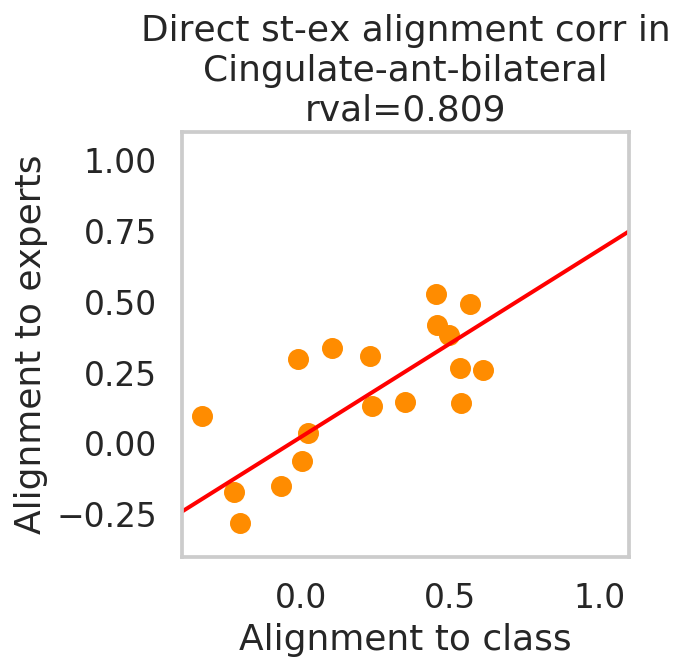

In [72]:
#part B - jpg - multiple regression lines like in placement

#this_dict_name='epi_recap_spatial_corr_bin_30s'
# assign raw individual st data to jpg_dict, was not saved in megadict
# NOTE rvals shown in title refer to mean across 29 bins all recaps, not within recap and then across recaps, so slight discrepency: for ms take correct vals from df
jpg_dict=epi_recap_spatial_corr_bin_30s
#this_dict[this_task][this_roi_name][this_hemi][vs]['rvals_per_student']['_vs_group'].shape
#total_nbins=0
coeffs=None

#for this_roi_name in ['Hippocampus','Precuneous','Cingulate-ant','Angular','Amygdala','Heschls','STG-post','Intracalcarine']:
for this_roi_name in ['Cingulate-ant']:
#for this_roi_name in masks.keys():
    for this_hemi in ['bilateral']:
        coeffs_df=pd.DataFrame() #n_bins in task X 3 [rval, coeff a, coeff b]
        #for i_this_task,this_task in enumerate(this_dict.keys()):
        for i_this_task,this_task in enumerate(jpg_dict.keys()):
            vs_group_data=jpg_dict[this_task][this_roi_name][this_hemi]['experts_vs_group']['rvals_per_student']['_vs_group'].copy()
            vs_experts_data=jpg_dict[this_task][this_roi_name][this_hemi]['experts_vs_group']['rvals_per_student']['_vs_experts'].copy()          
            for this_bin in np.arange(vs_group_data.shape[1]):
                x=vs_group_data[:,this_bin]
                y=vs_experts_data[:,this_bin]
                regline=np.polyfit(x, y, 1)
                rvals=func_corr_and_null_dist(x,y,num_perms=0)[0]
                temp_df=pd.DataFrame({'irecap': i_this_task,\
                                      'ibin': this_bin,\
                                      'rval':rvals,
                                      'coeff_a':regline[0],
                                      'coeff_b':regline[1]},index=[0])
                coeffs_df=coeffs_df.append(temp_df) # coeffs holds rvals, coeffs, for all bins in all recaps, this roi
        
        #get the bins for indivdual scatterplot figure
        individual_bins=np.array([i for i in list(np.argsort(-coeffs_df['rval'])[:3])]) # 3 students with top rvals
        
        #for individual_bin in individual_bins: # go over top bins in df
        for individual_bin in [16]: # select specific bin for 
            print(individual_bin)
            #plot trendlines figure
            sns.set_context('talk')
            f, ax = plt.subplots(1,1, figsize = (5, 5))
            ax.grid(b=None)
            for ibin in range(len(coeffs_df)):
                p=np.poly1d(coeffs_df.iloc[ibin][['coeff_a','coeff_b']].values)
                x=np.arange(-1.1,2.1)
                if ibin==individual_bin: # mark individual bin in next fig in red
                    clr='red'
                    ax.plot(x,p(x),clr,linewidth=2)
                elif coeffs_df['rval'].values[ibin]>0:
                    #clr='green'
                    clr='grey'
                    ax.plot(x,p(x),clr,linewidth=0.5) 
                else:
                    #clr='blue'  
                    clr='grey'
                    ax.plot(x,p(x),clr,linewidth=0.5)
            p=np.poly1d(coeffs_df[['coeff_a','coeff_b']].mean().values)
            x=np.arange(-1.1,2.1)
            #ax.plot(x,p(x),"red",linewidth=2)
            ax.plot(x,p(x),"black",linewidth=4)          
            plt.xlabel('Alignment to class')
            plt.ylabel('Alignment to experts')
            plt.xlim(-0.4,1.1)
            plt.ylim(-0.4,1.1)
            #title
            mean_rval=np.arctanh(np.mean(np.tanh(coeffs_df['rval'].values)))
            ax.set_title('Direct st-ex alignment corr in\n{}-{}\nrval={:.3f}'.format(this_roi_name,this_hemi,mean_rval,fontsize=10))           
            #save
            ax.grid(b=None)
            #save_filename=join(output_path,'vid_similarity_st_ex','jpg','recaps_{}-{}-direct-bin{}.ps'.format(this_roi_name,this_hemi,individual_bin))
            #plt.savefig(save_filename,dpi=150)
            #save_filename=join(output_path,'vid_similarity_st_ex','jpg','recaps_{}-{}-direct-bin{}.png'.format(this_roi_name,this_hemi,individual_bin))
            #plt.savefig(save_filename,dpi=150)

            # plot collapsed across bins
            # get recap and bin number for this individual bin
            irecap,ibin=coeffs_df.iloc[individual_bin][['irecap','ibin']].values.astype(np.int)
            # xy coords
            x = jpg_dict[list(this_dict.keys())[irecap]][this_roi_name][this_hemi]['experts_vs_group']['rvals_per_student']['_vs_group'][:,ibin]
            y = jpg_dict[list(this_dict.keys())[irecap]][this_roi_name][this_hemi]['experts_vs_group']['rvals_per_student']['_vs_experts'][:,ibin]
            #plot
            sns.set_context("talk")#, font_scale=1.2)
            f, ax = plt.subplots(1,1, figsize = (5, 5))
            ax.scatter(x,y,color='darkorange')
            
            # trendline
            z=np.polyfit(x, y, 1)
            p = np.poly1d(z)
            pltx=np.arange(-1.1,2.1) # extend trandline to axes
            ax.plot(pltx,p(pltx),"r",linewidth=2)
            # save to recreate fig
            pltx_save[:,ibin]=pltx
            plty_save[:,ibin]=p(pltx)
            # labels
            plt.xlabel('Alignment to class')
            plt.ylabel('Alignment to experts')
            plt.xlim(-0.4,1.1)
            plt.ylim(-0.4,1.1)
            this_bin_rval=coeffs_df['rval'].values[individual_bin]
            ax.set_title('Direct st-ex alignment corr in\n{}-{}\nrval={:.3f}'.format(this_roi_name,this_hemi,this_bin_rval,fontsize=10))                  
            sns.set_style("whitegrid", {'axes.grid' : False})
            #save           
            #save_filename=join(output_path,'vid_similarity_st_ex','jpg','single_subject','recaps_{}-{}-direct-bin{}.ps'.format(this_roi_name,this_hemi,individual_bin))
            #plt.savefig(save_filename,dpi=150)
            #save_filename=join(output_path,'vid_similarity_st_ex','jpg','single_subject','recaps_{}-{}-direct-bin{}.png'.format(this_roi_name,this_hemi,individual_bin))
            #plt.savefig(save_filename,dpi=150)

            

    

In [73]:
# show x,y for figure 3
x
y
coeffs_df


array([ 0.23018255,  0.0027728 ,  0.45618652, -0.3342973 ,  0.3466052 ,
       -0.41885273, -0.2258044 , -0.4391284 ,  0.02313888, -0.01237421,
        0.45254945,  0.49478564, -0.20604403,  0.56531302,  0.53278713,
       -0.06825042,  0.23820945,  0.60857795,  0.10285947,  0.53423276])

array([ 0.3083655 , -0.06190647,  0.41735735,  0.09547779,  0.1473732 ,
       -0.50817172, -0.17329685, -0.29263166,  0.03852308,  0.29805841,
        0.52865763,  0.38140198, -0.28133681,  0.4935457 ,  0.26755457,
       -0.15117034,  0.13186137,  0.25920179,  0.33694055,  0.14222334])

,irecap,ibin,rval,coeff_a,coeff_b
0,0,0,-0.855614,-0.420780,-0.006044
0,0,1,0.635352,0.406553,0.041185
0,0,2,0.729378,1.511719,0.018463
0,0,3,-0.084582,-0.070786,-0.033907
0,0,4,-0.046598,-0.040258,0.000074
0,0,5,0.604177,0.498252,0.065367
0,1,0,-0.234548,-0.140118,-0.025077
0,1,1,-0.775320,-0.730142,0.061474
0,1,2,-0.622874,-0.585587,0.030313
0,1,3,-0.179109,-0.302135,0.072329


Part (3): Analyze lecture videos

In [ ]:
# LECTURES 


pickle_dicts=['epi_lecture_temp_corr_no_bin','epi_lecture_spatial_corr_per_tr','epi_lecture_spatial_corr_bin_10s','epi_lecture_spatial_corr_bin_30s']
load_from_pickle=False
if load_from_pickle:
    for this_dict in pickle_dicts:
        pickle_filename=join(pickles_path,'lectures_roi_data_isc_meanbin_dict_nothr_{}.p'.format(this_dict)) # temporal and spatial (spatial averaged over time bins)
        exec('{}=pickle.load(open(pickle_filename, \'rb\'))'.format(this_dict))
else: # redo, no load from pickle

    # temporal correlations, no binning
    epi_lecture_temp_corr_no_bin={} # repeat for spatial/temp. binning 10s, 30s, not just raw
    # spatial correlation, per tr and w bin 30s,10s
    epi_lecture_spatial_corr_per_tr={}
    tr_length=2
    bin_size_seconds_10=10
    epi_lecture_spatial_corr_bin_10s={}
    bin_size_seconds_30=30
    epi_lecture_spatial_corr_bin_30s={}

    lectures=sorted([r for r in all_sessions_and_tasks if 'vid' in r])
    task_name_template=".*(s\d{3}).*(wk\d+)_([0-9a-zA-Z]*)_6motion_mni" # identify subject, session, task
    for this_task in lectures:
        #init dict for task
        epi_lecture_temp_corr_no_bin[this_task]={}
        epi_lecture_spatial_corr_per_tr[this_task]={}
        epi_lecture_spatial_corr_bin_10s[this_task]={}
        epi_lecture_spatial_corr_bin_30s[this_task]={}
        for this_roi_name in sorted(masks.keys()): # iterate over all rois
            # init dict for roi
            epi_lecture_temp_corr_no_bin[this_task][this_roi_name]={}
            epi_lecture_spatial_corr_per_tr[this_task][this_roi_name]={}
            epi_lecture_spatial_corr_bin_10s[this_task][this_roi_name]={}
            epi_lecture_spatial_corr_bin_30s[this_task][this_roi_name]={}
            for this_hemisphere in hemispheres:
                #init dict for hemisphere
                epi_lecture_temp_corr_no_bin[this_task][this_roi_name][this_hemisphere]={}
                epi_lecture_spatial_corr_per_tr[this_task][this_roi_name][this_hemisphere]={}
                epi_lecture_spatial_corr_bin_10s[this_task][this_roi_name][this_hemisphere]={}
                epi_lecture_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]={}

                #student data
                full_or_thresholded='full_roi' 
                print('{}-{}-{}-{}'.format(this_task,this_roi_name,this_hemisphere,full_or_thresholded))
                this_data=epi_tasks_in_roi['students'][this_task]['roi_data'][this_roi_name][this_hemisphere]
                this_data_transformed=transform_srm_space_to_isc_space(this_data) # vox, tr, sub - already zscored on time          

                # temporal correlations
                # for student vs other students mean mean corr (same video)
                corr_student_vs_other_students_temporal=np.zeros(this_data_transformed.shape[2],) 
                # iterate over students
                for i_this_student in range(len(corr_student_vs_other_students_temporal)):
                    # for every student, corr with all other students
                    this_student_mean_over_voxels=np.mean(this_data_transformed[:,:,i_this_student],0)
                    other_students = np.mean(this_data_transformed[:, :, np.arange(this_data_transformed.shape[2]) != i_this_student], axis=2)
                    other_students_mean_over_voxels=np.mean(other_students,0)
                    rval_vs_other_students=stats.pearsonr(this_student_mean_over_voxels,other_students_mean_over_voxels)
                    corr_student_vs_other_students_temporal[i_this_student]=rval_vs_other_students[0]
                #update dict     
                epi_lecture_temp_corr_no_bin[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=corr_student_vs_other_students_temporal # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_lecture_temp_corr_no_bin[this_task][this_roi_name][this_hemisphere]['student_names']=students_list

                # spatial correlations
                number_of_bins_10s=np.int(np.floor(this_data_transformed.shape[1]/(bin_size_seconds_10/tr_length)))
                number_of_bins_30s=np.int(np.floor(this_data_transformed.shape[1]/(bin_size_seconds_30/tr_length)))
                # for student vs other students mean mean corr (same video)
                corr_student_vs_other_students_spatial_per_tr=np.zeros([this_data_transformed.shape[2],this_data_transformed.shape[1]]) 
                corr_student_vs_other_students_spatial_10s=np.zeros([this_data_transformed.shape[2],number_of_bins_10s]) 
                corr_student_vs_other_students_spatial_30s=np.zeros([this_data_transformed.shape[2],number_of_bins_30s]) 
                # iterate over students
                for i_this_student in range(len(corr_student_vs_other_students_spatial_30s)):
                    # for every student, corr with all other students
                    # per tr
                    this_student_all_trs=this_data_transformed[:,:,i_this_student]
                    other_students = np.mean(this_data_transformed[:, :, np.arange(this_data_transformed.shape[2]) != i_this_student], axis=2) #mean over (other) students
                    temp=np.array([stats.pearsonr(this_student_all_trs[:,i_tr],other_students[:,i_tr])[0] for i_tr in range(this_data_transformed.shape[1])])
                    corr_student_vs_other_students_spatial_per_tr[i_this_student]=temp
                    # 10s bins
                    this_student_mean_over_bins_10s=func_mean_over_trs(this_data_transformed[:,:,i_this_student],bin_size=10)              
                    other_students_mean_over_bins_10s=func_mean_over_trs(other_students,bin_size=10)
                    corr_student_vs_other_students_spatial_10s[i_this_student]=np.array([stats.pearsonr(this_student_mean_over_bins_10s[:,i],other_students_mean_over_bins_10s[:,i])[0] for i in range(number_of_bins_10s)])
                    # 30s bins
                    this_student_mean_over_bins_30s=func_mean_over_trs(this_data_transformed[:,:,i_this_student])              
                    other_students_mean_over_bins_30s=func_mean_over_trs(other_students)
                    corr_student_vs_other_students_spatial_30s[i_this_student]=np.array([stats.pearsonr(this_student_mean_over_bins_30s[:,i],other_students_mean_over_bins_30s[:,i])[0] for i in range(number_of_bins_30s)])
                #update dict with the value for mean of bins 
                #no bins
                epi_lecture_spatial_corr_per_tr[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=np.mean(corr_student_vs_other_students_spatial_per_tr,1) # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_lecture_spatial_corr_per_tr[this_task][this_roi_name][this_hemisphere]['student_names']=students_list
                #10s bins
                epi_lecture_spatial_corr_bin_10s[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=np.mean(corr_student_vs_other_students_spatial_10s,1) # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_lecture_spatial_corr_bin_10s[this_task][this_roi_name][this_hemisphere]['student_names']=students_list
                #30s bins
                epi_lecture_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['rvals_vs_group']=np.mean(corr_student_vs_other_students_spatial_30s,1) # USE TO STORE CORR DATA WITH group (other students)
                students_list=[re.search(task_name_template,this_file)[1] for this_file in epi_tasks_in_roi['students'][this_task]['filenames']] # student names
                epi_lecture_spatial_corr_bin_30s[this_task][this_roi_name][this_hemisphere]['student_names']=students_list

    do_pickle=True
    dicts_to_save=['epi_lecture_temp_corr_no_bin','epi_lecture_spatial_corr_per_tr','epi_lecture_spatial_corr_bin_10s','epi_lecture_spatial_corr_bin_30s']
    if do_pickle:
        for this_dict in dicts_to_save:
            pickle_filename=join(pickles_path,'lectures_roi_data_isc_meanbin_dict_nothr_{}.p'.format(this_dict)) # temporal and spatial (spatial averaged over time bins)
            pickle.dump(eval(this_dict), open(pickle_filename, 'wb'))


wk1_vid1-Amygdala-bilateral-full_roi
wk1_vid1-Angular-bilateral-full_roi
wk1_vid1-Cingulate-ant-bilateral-full_roi
wk1_vid1-Heschls-bilateral-full_roi
wk1_vid1-Hippocampus-bilateral-full_roi
wk1_vid1-Intracalcarine-bilateral-full_roi
wk1_vid1-Precuneous-bilateral-full_roi
wk1_vid1-STG-post-bilateral-full_roi
wk1_vid2-Amygdala-bilateral-full_roi
wk1_vid2-Angular-bilateral-full_roi
wk1_vid2-Cingulate-ant-bilateral-full_roi
wk1_vid2-Heschls-bilateral-full_roi
wk1_vid2-Hippocampus-bilateral-full_roi
wk1_vid2-Intracalcarine-bilateral-full_roi
wk1_vid2-Precuneous-bilateral-full_roi
wk1_vid2-STG-post-bilateral-full_roi
wk1_vid3-Amygdala-bilateral-full_roi
wk1_vid3-Angular-bilateral-full_roi
wk1_vid3-Cingulate-ant-bilateral-full_roi
wk1_vid3-Heschls-bilateral-full_roi
wk1_vid3-Hippocampus-bilateral-full_roi
wk1_vid3-Intracalcarine-bilateral-full_roi
wk1_vid3-Precuneous-bilateral-full_roi
wk1_vid3-STG-post-bilateral-full_roi
wk1_vid4-Amygdala-bilateral-full_roi
wk1_vid4-Angular-bilateral-full_r

In [93]:

# LECTURES
# mean over tasks -lectures
pickle_dicts=['epi_lecture_temp_corr_no_bin','epi_lecture_spatial_corr_per_tr','epi_lecture_spatial_corr_bin_10s','epi_lecture_spatial_corr_bin_30s']
megadict['lectures']={}


placement_df=outcomes_df.dropna()['placement'] # drop students with Nans


for this_dict_name in pickle_dicts:
    print(this_dict_name)
    this_dict=eval(this_dict_name).copy()


    this_task=None
    this_roi=None
    mean_over_tasks_dict={} # mean over all tasks 
    all_tasks_dict={} # all tasks data - for use as features later

    #this_task=for this_task in this_dict.keys():
    vs = 'rvals_vs_group'



    for this_roi_name in sorted(masks.keys()):
        print(this_roi_name)
        mean_over_tasks_dict[this_roi_name]={}
        all_tasks_dict[this_roi_name]={}
        for this_hemi in hemispheres:
            mean_over_tasks_dict[this_roi_name][this_hemi]={}
            all_tasks_dict[this_roi_name][this_hemi]={}
            print(this_hemi)

            mean_over_tasks_dict[this_roi_name][this_hemi][vs]={}
            all_tasks_dict[this_roi_name][this_hemi][vs]={}
            null_task=list(this_dict.keys())[0]
            n_sub=len(placement_df[good_students])
            # all_corrs: mean over all tasks
            all_corrs=np.zeros([n_sub,len(this_dict.keys())]) # subjects, tasks
            all_corrs[:] = np.nan
            for i_this_task,this_task in enumerate(this_dict.keys()):           
                # get students data, sorted (if forgot to read sorted)
                v=this_dict[this_task][this_roi_name][this_hemi]['student_names'].copy()
                data_sorted=this_dict[this_task][this_roi_name][this_hemi][vs][np.argsort(v)]
                # skip students with no data in this task (s103 task 3)
                all_corrs_ind=[True if s in v else False for s in sorted(good_students)]
                # load data
                all_corrs[all_corrs_ind,i_this_task]=data_sorted
            # update dict - mean after fisher
            mean_over_tasks_dict[this_roi_name][this_hemi][vs]=np.tanh(np.nanmean(np.arctanh(all_corrs),axis=1))
            mean_over_tasks_dict[this_roi_name][this_hemi]['student_names']=this_dict[this_task][this_roi_name][this_hemi]['student_names'].copy()
            # update tasks dict - all
            all_tasks_dict[this_roi_name][this_hemi][vs]=all_corrs #subjects*tasks
            all_tasks_dict[this_roi_name][this_hemi]['student_names']=this_dict[this_task][this_roi_name][this_hemi]['student_names'].copy()

    # update data (pickled,original) dict
    this_dict['mean_over_tasks']=mean_over_tasks_dict
    this_dict['all_tasks']=all_tasks_dict
    megadict['lectures'][this_dict_name]=this_dict.copy()
    # note nans for s103 for wk3
    #all_tasks_dict['V4']['right']['rvals_vs_group'][1,:]

epi_lecture_temp_corr_no_bin
Amygdala
bilateral
Angular
bilateral
Cingulate-ant
bilateral
Heschls
bilateral
Hippocampus
bilateral
Intracalcarine
bilateral
Precuneous
bilateral
STG-post
bilateral
epi_lecture_spatial_corr_per_tr
Amygdala
bilateral
Angular
bilateral
Cingulate-ant
bilateral
Heschls
bilateral
Hippocampus
bilateral
Intracalcarine
bilateral
Precuneous
bilateral
STG-post
bilateral
epi_lecture_spatial_corr_bin_10s
Amygdala
bilateral
Angular
bilateral
Cingulate-ant
bilateral
Heschls
bilateral
Hippocampus
bilateral
Intracalcarine
bilateral
Precuneous
bilateral
STG-post
bilateral
epi_lecture_spatial_corr_bin_30s
Amygdala
bilateral
Angular
bilateral
Cingulate-ant
bilateral
Heschls
bilateral
Hippocampus
bilateral
Intracalcarine
bilateral
Precuneous
bilateral
STG-post
bilateral


In [94]:
# select 
this_dict_name='epi_lecture_spatial_corr_bin_30s' # spatial 30s bins
#this_dict_name='epi_lecture_spatial_corr_bin_10s' # spatial 10s bins
#this_dict_name='epi_lecture_spatial_corr_per_tr' # spatial 2s bins
#this_dict_name='epi_lecture_temp_corr_no_bin' # temporal


In [95]:
# LECTURES
# corr mean over tasks with placement score

num_perms=1000
corrw_outcome_df=pd.DataFrame() # results
this_dict=megadict['lectures'][this_dict_name]['mean_over_tasks'].copy()

for this_score_type in ['placement']:
    score_df=outcomes_df.dropna()[this_score_type]
    for this_roi_name in sorted(this_dict.keys()): # iter ROIs
        for this_hemi in hemispheres:
            for vs in ['rvals_vs_group']:
                cx=this_dict[this_roi_name][this_hemi][vs]
                x=cx.copy()
                y=score_df[good_students].values
                rval, dist = func_corr_and_null_dist(x,y,num_perms=num_perms)
                if np.isnan(rval) or np.sum(np.isnan(dist)):
                    pval=np.nan
                else:
                    pval = isc.p_from_null(rval,dist,side='right',exact=False,axis=0)

                vs_mean_of='student-vs-experts' if 'expert' in vs else 'student-vs-students'
                nvox=int(np.sum(masks[this_roi_name]['all_voxels'][this_hemi]))
                temp_df=pd.DataFrame({'corr_w_score': 'between',\
                                                       'score_type': this_score_type,\
                                                       'isc_type': 'spatial_bin30s',\
                                                       'roi_type': 'anatomical',\
                                                       'vs_mean_of': vs_mean_of,\
                                                       'across': 'lectures',\
                                                       'roi_name': this_roi_name,\
                                                       'roi_hemi': this_hemi,\
                                                       'n_voxels':nvox,\
                                                       'rval':rval,\
                                                       'pval':pval},index=[0])
                corrw_outcome_df=corrw_outcome_df.append(temp_df)



In [96]:
# LECTURES
# table 2 column 'lectures'
# plot mean across tasks correlation with outcome

#corrw_outcome_df
# filter similarity df by params
outcome_df=corrw_outcome_df.copy() # reset filtering

# dict for filter with all unique vals and selected vals
outcome_roi_keys={}
for this_col_name in outcome_df.columns:
    outcome_roi_keys[this_col_name]={}
    outcome_roi_keys[this_col_name]['all']=sorted(outcome_df[this_col_name].unique()) # all unique values in that column
    outcome_roi_keys[this_col_name]['select']=None # selected value to filter

# set filtering params
rois_effect=['Hippocampus','Precuneous','Cingulate-ant','Angular','STG-post']
rois_control=['Amygdala','Heschls','Intracalcarine']

for outcome_roi_keys['score_type']['select'] in [['placement']]:
    for outcome_roi_keys['roi_name']['select'] in [rois_effect+rois_control]:
        for outcome_roi_keys['vs_mean_of']['select'] in [['student-vs-students']]:
            outcome_roi_keys['roi_hemi']['select']=['bilateral']
            #outcome_roi_keys['roi_hemi']['select']=['right','left']
            this_data_outcome=get_filtered_df(roi_keys=outcome_roi_keys,unfiltered_df=outcome_df)
            # fix names and order of ROIS
            replace_dict={'Intracalcarine':'_Intracalc','Precuneous':'Precuneus','Cingulate-ant':'Cingulate(a)'}
            this_data_outcome.replace(to_replace=replace_dict,inplace=True)
            this_data_outcome=this_data_outcome.sort_values(['roi_name'])
            # FDR corrected pval
            this_data_outcome['fdr_pval']=fdr_correction(this_data_outcome.pval)[1]
            # disp df
            this_data_outcome
            # output filename
            fn=None
            #fn=join(output_path,'placement','outcome','focus',get_title_text(outcome_roi_keys,'lectures-collapsed-{}'.format(this_dict_name))+'.jpg')
            #plot_df_roi(filtered_df=this_data_outcome,roi_keys=outcome_roi_keys,save_filename=fn)
    



,corr_w_score,score_type,isc_type,roi_type,vs_mean_of,across,roi_name,roi_hemi,n_voxels,rval,pval,fdr_pval
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,Amygdala,bilateral,318,0.293296,0.125874,0.125874
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,Angular,bilateral,1783,0.620351,0.000999,0.003996
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,Cingulate(a),bilateral,1092,0.525319,0.009990,0.019980
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,Heschls,bilateral,454,0.456410,0.027972,0.044755
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,Hippocampus,bilateral,668,0.752559,0.000999,0.003996
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,Precuneus,bilateral,2845,0.608211,0.001998,0.005328
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,STG-post,bilateral,856,0.403230,0.039960,0.045669
0,between,placement,spatial_bin30s,anatomical,student-vs-students,lectures,_Intracalc,bilateral,925,0.408804,0.035964,0.045669


df_rval = [0.75255944]
dict_rval = 0.7525594419571001


Text(0.5, 1.0, 'Hippocampus')

Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Exam score')

df_rval = [0.52531885]
dict_rval = 0.5253188525935947


Text(0.5, 1.0, 'Cingulate-ant')

Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Exam score')

df_rval = [0.62035147]
dict_rval = 0.6203514710006768


Text(0.5, 1.0, 'Angular')

Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Exam score')

df_rval = [0.40880418]
dict_rval = 0.40880418468264773


Text(0.5, 1.0, 'Intracalcarine')

Text(0.5, 0, 'Alignment to class')

Text(0, 0.5, 'Exam score')

<Figure size 432x288 with 0 Axes>

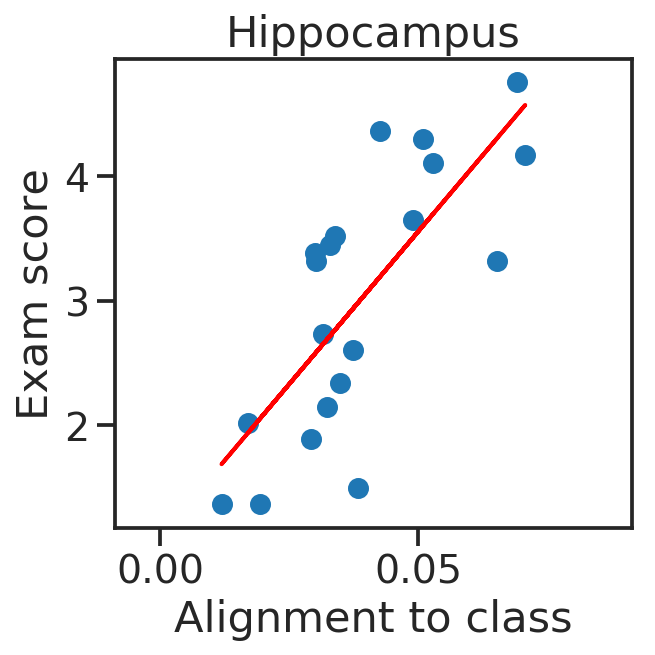

<Figure size 432x288 with 0 Axes>

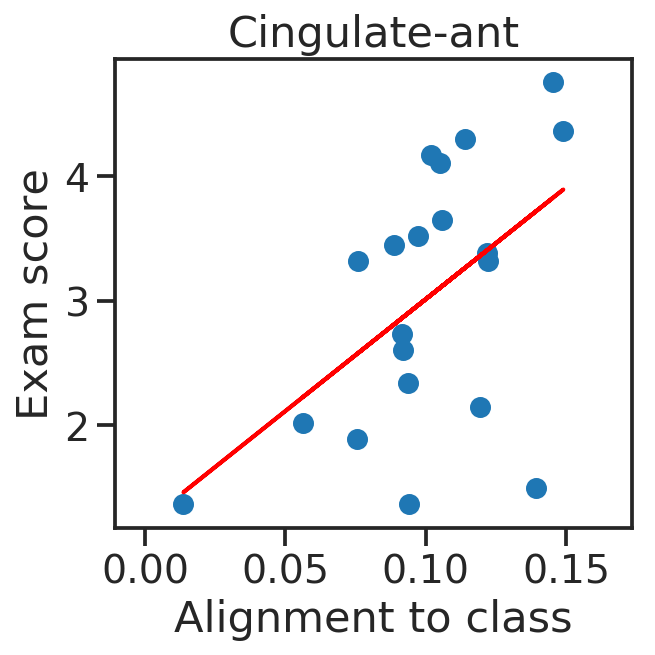

<Figure size 432x288 with 0 Axes>

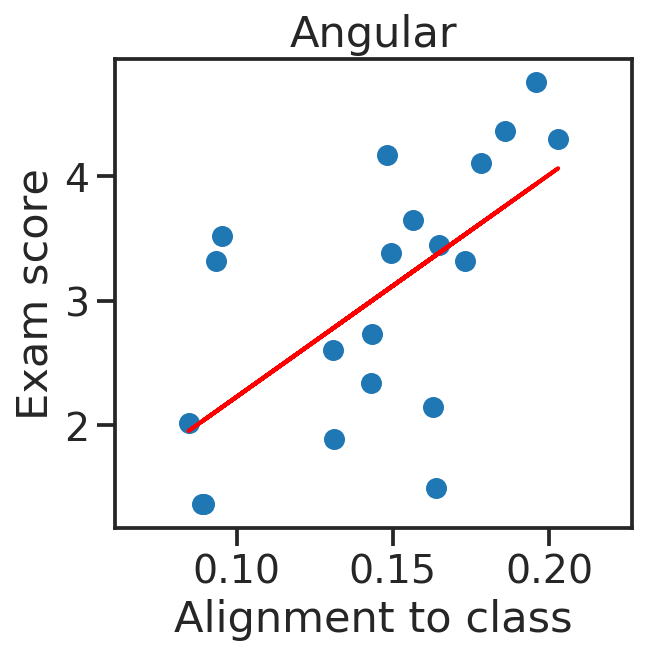

<Figure size 432x288 with 0 Axes>

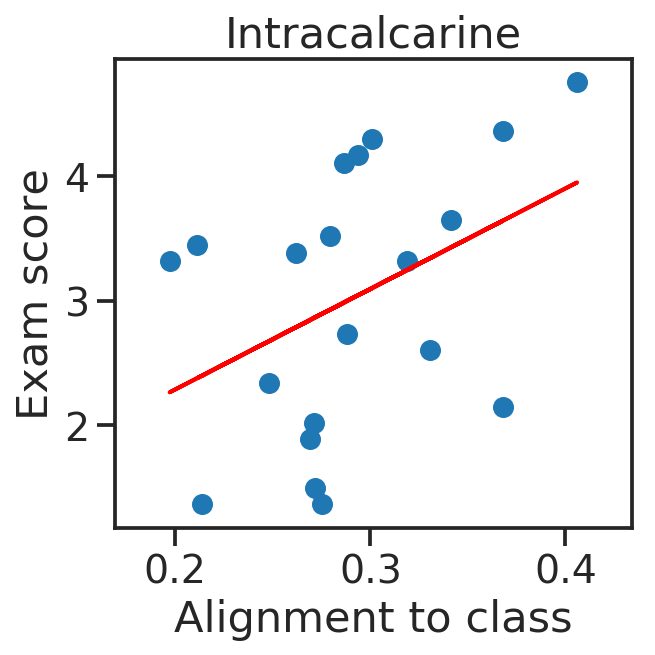

In [99]:
# LECTURES

# plot correlation of mean over tasks with placement score
outcome_df=corrw_outcome_df.copy() # reset filtering
#outcome_df
placement_df=outcomes_df.dropna()['placement']
# select ROI data

good_students_mask=[True if s in placement_df.index else False for s in this_dict[this_roi_name][this_hemi]['student_names']]
num_good_students=np.sum(good_students_mask)
save_jpg=True

for this_roi_name in ['Hippocampus','Cingulate-ant','Angular','Intracalcarine']:
#this_roi_name='Hippocampus'
    #for this_hemi in hemispheres:
    for this_hemi in ['bilateral']:
        #this_hemi='left'
        vs='rvals_vs_group'
        outcome_roi_keys['roi_name']['select']=this_roi_name
        outcome_roi_keys['score_type']['select']='placement'

        cx=this_dict[this_roi_name][this_hemi][vs]#[good_students_mask]
        #x = np.tanh(cx)
        x=cx.copy()
        y=placement_df[good_students].values
        y*=100/(3*16)
        # recalc rval
        rval, dist = func_corr_and_null_dist(x,y,num_perms=0)
        # get pval
        # dict for filter with all unique vals and selected vals
        outcome_roi_keys={}
        for this_col_name in outcome_df.columns:
            outcome_roi_keys[this_col_name]={}
            outcome_roi_keys[this_col_name]['all']=sorted(outcome_df[this_col_name].unique()) # all unique values in that column
            outcome_roi_keys[this_col_name]['select']=None # selected value to filter
        #corrw_outcome_df
        # filter similarity df by params
        outcome_df=corrw_outcome_df.copy() # reset filtering
        # select w params
        outcome_roi_keys['roi_name']['select']=[this_roi_name]
        outcome_roi_keys['roi_hemi']['select']=[this_hemi]
        outcome_roi_keys['roi_type']['select']=['anatomical']
        outcome_roi_keys['vs_mean_of']['select']=['student-vs-students']
        this_data_outcome=get_filtered_df(roi_keys=outcome_roi_keys,unfiltered_df=outcome_df)
        pval=this_data_outcome['pval'].values[0]
        # compare rvals between dict and df - should be identical
        print('df_rval = {}'.format(this_data_outcome['rval'].values))
        print('dict_rval = {}'.format(rval))
        sns.set_context("talk", font_scale=1.2)
        sns.set_style("ticks")
        fig=plt.figure()
        f, ax = plt.subplots(1,1, figsize = (5, 5))
        #ax = fig.add_subplot(111)
        ax.scatter(x,y)
        #ax.grid(b=None)
        # trendline
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        ax.plot(x,p(x),"r",linewidth=2)
        plt.title(this_roi_name)
        plt.xlabel('Alignment to class')
        plt.ylabel('Exam score')
        lim_x=ax.get_xlim()
#         if save_jpg:
#             save_filename=join(output_path,'vid_corrw_score','jpg','lec_corrw_{}-{}_thr{}.ps'.format(this_roi_name,this_hemi,thr))
#             plt.savefig(save_filename,dpi=150)
#             save_filename=join(output_path,'vid_corrw_score','jpg','lec_corrw_{}-{}_thr{}.png'.format(this_roi_name,this_hemi,thr))
#             plt.savefig(save_filename,dpi=150)

In [102]:
# show data for figure 2
for this_roi_name in ['Hippocampus','Cingulate-ant','Angular','Intracalcarine']:
    this_roi_name
    cx=this_dict[this_roi_name][this_hemi][vs]#[good_students_mask]
    x=cx.copy()
    y=placement_df[good_students].values
    y*=100/(3*16)
    temp=pd.DataFrame({'x':x,'y':y})
    temp

'Hippocampus'

,x,y
0,0.031575,2.734375
1,0.029228,1.888021
2,0.030027,3.385417
3,0.048897,3.645833
4,0.069137,4.752604
5,0.070681,4.166667
6,0.032938,3.450521
7,0.050865,4.296875
8,0.011910,1.367188
9,0.042508,4.361979


'Cingulate-ant'

,x,y
0,0.091604,2.734375
1,0.075610,1.888021
2,0.121753,3.385417
3,0.105775,3.645833
4,0.145253,4.752604
5,0.101969,4.166667
6,0.088679,3.450521
7,0.113873,4.296875
8,0.094083,1.367188
9,0.149055,4.361979


'Angular'

,x,y
0,0.143279,2.734375
1,0.131323,1.888021
2,0.149355,3.385417
3,0.156332,3.645833
4,0.195947,4.752604
5,0.148265,4.166667
6,0.164784,3.450521
7,0.202906,4.296875
8,0.088768,1.367188
9,0.185801,4.361979


'Intracalcarine'

,x,y
0,0.288067,2.734375
1,0.268900,1.888021
2,0.261873,3.385417
3,0.341490,3.645833
4,0.405971,4.752604
5,0.293526,4.166667
6,0.211422,3.450521
7,0.300962,4.296875
8,0.213864,1.367188
9,0.367830,4.361979
